In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample 
import scanpy as sc
import seaborn as sns
import anndata as ad
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/'
anndata_objects = []
name_anndata = "A1-1"+"/"+"anndataNucA11"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
name_anndata = "A1-2"+"/"+"anndataNucA12"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
name_anndata = "C2"+"/"+"anndataNucC2"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
name_anndata = "D2-1"+"/"+"anndataNucD21"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
anndata_objects.append(anndata)
#name_anndata = "PS"+"/"+"ps_slice"
#anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_shape_distances')
#anndata_objects.append(anndata)
#samples = ["A1-1", "A1-2", "C2", "D2-1", "PS"]
samples = ["A1-1", "A1-2", "C2", "D2-1"]

In [3]:
for anndata in anndata_objects:
    print(anndata.shape)

(11283, 99)
(8695, 95)
(27133, 100)
(12519, 99)


In [4]:
# Give Leiden clusters unique numbers over all samples
nr_leiden_clusters = []
for i in range(len(anndata_objects)):
    nr_leiden_clusters.append(len(np.unique(anndata_objects[i].obs['leiden'])))
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype(int) + sum(nr_leiden_clusters[:i])
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype(str)
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype('category')

In [3]:
anndata_samples_together = anndata_objects[0].concatenate(anndata_objects[1],anndata_objects[2],anndata_objects[3])
#anndata_samples_together = anndata_objects[0].concatenate(anndata_objects[1],anndata_objects[2],anndata_objects[3],anndata_objects[4])

In [62]:
columns = ['% >0','mean of >0','median of >0','Q1 of >0','Q3 of >0','variance of >0']
rows=anndata_samples_together.var_names
columns=columns
df = pd.DataFrame(index=rows, columns=columns)
for i in range(len(anndata_samples_together.var_names)):
    a = anndata_samples_together.layers['raw_counts'][:,i]
    a = a[a>0]
    df.iloc[i] = [round(100*len(a)/len(anndata_samples_together.obs_names),2),np.round(np.mean(a),2),np.round(np.median(a),2),np.round(np.quantile(a,0.25),2),np.round(np.quantile(a,0.75),2),np.round(a.var(),1)]
# add column with SD
if (df['variance of >0'] != np.dtype('float')).any():
            df['variance of >0'] = df['variance of >0'].astype('float')
df['SD of >0'] = np.round(np.sqrt(df['variance of >0']),2)
df = df.sort_values(by=['mean of >0'],ascending=False)
df

,% >0,mean of >0,median of >0,Q1 of >0,Q3 of >0,variance of >0,SD of >0
Cyp2e1,59.03,64.07,38.0,12.0,101.0,4553.0,67.48
Pck1,92.18,43.99,25.0,8.0,67.0,2318.8,48.15
Spp1,4.11,34.68,19.0,2.0,57.0,1634.0,40.42
Fn1,91.73,18.37,13.0,5.0,27.0,290.3,17.04
Clec4f,24.47,11.01,5.0,2.0,16.0,183.3,13.54
...,...,...,...,...,...,...,...
Trem2,0.62,1.16,1.0,1.0,1.0,0.3,0.55
Atp6v0d2,6.05,1.14,1.0,1.0,1.0,0.2,0.45
Krt19,0.27,1.06,1.0,1.0,1.0,0.1,0.32
Folr2,0.83,1.04,1.0,1.0,1.0,0.0,0.00


In [63]:
# get indices of rows with median > 0 equal to 2.0 and % > 0 smaller than 10
indices = df[(df['% >0'] < 16) & (df['% >0'] > 10)].index
indices

Index(['Col1a1', 'Reln', 'Adgre1', 'Vsig4', 'Lyve1', 'Clec9a', 'Sox9', 'Lpl'], dtype='object')

In [64]:
df.loc['Clec9a']

% >0              12.38
mean of >0         2.39
median of >0        1.0
Q1 of >0            1.0
Q3 of >0            2.0
variance of >0     14.5
SD of >0           3.81
Name: Clec9a, dtype: object

In [65]:
random_genes = ['Pck1','Ghr','Cyp2e1','Prox1','Sds','Cd5l','Dpt','Spp1']
random_genes_perc_count = []
for gene in random_genes:
    random_genes_perc_count.append(round(df.loc[gene]['% >0'],1))
random_genes_perc_count 

[92.2, 80.9, 59.0, 58.8, 44.2, 29.1, 9.1, 4.1]

In [66]:
df = df.sort_values(by=['median of >0'],ascending=False)
data = df['median of >0']
Q1 = np.percentile(data, 25, interpolation = 'midpoint') 
Q2 = np.percentile(data, 50, interpolation = 'midpoint') 
Q3 = np.percentile(data, 75, interpolation = 'midpoint') 
IQR = Q3 - Q1
outliers = []
outliers_names = []
count = 0
for i in data:
    if i > Q3 + 1.5 * IQR or i < Q1 - 1.5 * IQR:
        outliers.append(i)
        outliers_names.append(df.index[count])
    count += 1
print(outliers_names)
print(outliers)

['Cyp2e1', 'Pck1', 'Spp1', 'Fn1', 'Stab2', 'Sds', 'Cd79a', 'Clec4f', 'Vwf', 'Cd5l', 'Cd3e', 'Ghr']
[38.0, 25.0, 19.0, 13.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0]


In [67]:
data = df['% >0']
Q1 = np.percentile(data, 25, interpolation = 'midpoint') 
Q2 = np.percentile(data, 50, interpolation = 'midpoint') 
Q3 = np.percentile(data, 75, interpolation = 'midpoint') 
IQR = Q3 - Q1
outliers_perc = []
outliers_names_perc = []
count = 0
for i in data:
    if i > Q3 + 1.5 * IQR or i < Q1 - 1.5 * IQR:
        outliers_perc.append(i)
        outliers_names_perc.append(df.index[count])
    count += 1
print(outliers_perc)
print(outliers_names_perc)

[59.03, 92.18, 91.73, 80.86, 61.07, 52.91, 58.8]
['Cyp2e1', 'Pck1', 'Fn1', 'Ghr', 'Ngfr', 'Hal', 'Prox1']


In [68]:
# outliers_names and outliers_names_perc together
outliers_names_together = outliers_names + outliers_names_perc
outliers_names_together = list(dict.fromkeys(outliers_names_together))
print(outliers_names_together)
print(len(outliers_names_together))
# outliers in outliers_names but not in outliers_names_perc
outliers_names_only = [x for x in outliers_names if x not in outliers_names_perc]
outliers_names_perc_only = [x for x in outliers_names_perc if x not in outliers_names]
outliers_names_both = [x for x in outliers_names if x in outliers_names_perc]
print(outliers_names_only)
print(outliers_names_perc_only)
print(outliers_names_both)

['Cyp2e1', 'Pck1', 'Spp1', 'Fn1', 'Stab2', 'Sds', 'Cd79a', 'Clec4f', 'Vwf', 'Cd5l', 'Cd3e', 'Ghr', 'Ngfr', 'Hal', 'Prox1']
15
['Spp1', 'Stab2', 'Sds', 'Cd79a', 'Clec4f', 'Vwf', 'Cd5l', 'Cd3e']
['Ngfr', 'Hal', 'Prox1']
['Cyp2e1', 'Pck1', 'Fn1', 'Ghr']


In [69]:
outliers_index_only = []
for i in outliers_names_only:
    outliers_index_only.append(df.index.get_loc(i))
outliers_index_perc_only = []
for i in outliers_names_perc_only:
    outliers_index_perc_only.append(df.index.get_loc(i))
outliers_index_both = []
for i in outliers_names_both:
    outliers_index_both.append(df.index.get_loc(i))
# split df in outliers and non-outliers
df_outliers_only = df.iloc[outliers_index_only]
df_outliers_perc_only = df.iloc[outliers_index_perc_only]
df_outliers_both = df.iloc[outliers_index_both]
df_non_outliers = df.copy(deep=True)
df_non_outliers = df_non_outliers.drop(outliers_names_together)
print(len(df_non_outliers))
print(len(df_outliers_only))
print(len(df_outliers_perc_only))
print(len(df_outliers_both))

80
8
3
4


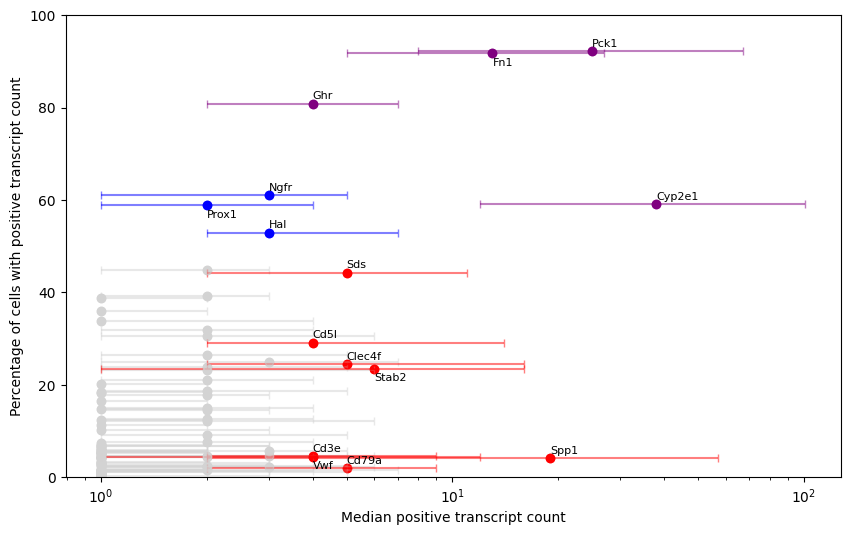

In [70]:
df_real = df.copy(deep=True)

plt.figure(figsize=(10,6))

df = df_non_outliers
color = 'lightgray'
df = df.copy(deep=True)
plt.scatter(df['median of >0'],df['% >0'],color=color)
#for i in range(len(df)):
    #plt.text(df['median of >0'][i],df['% >0'][i]+2,df.index[i],fontsize=8,color=color)       
plt.errorbar(df['median of >0'],df['% >0'],xerr=[df['median of >0']-df['Q1 of >0'],df['Q3 of >0']-df['median of >0']],yerr=0,fmt='o',capsize=3,alpha=0.5,color=color)

df = df_outliers_perc_only
color = 'blue'
df = df.copy(deep=True)
plt.scatter(df['median of >0'],df['% >0'],color=color)
for i in range(len(df)):
    if df.index[i] in ['Prox1'] :
        plt.text(df['median of >0'][i],df['% >0'][i]-2.6,df.index[i],fontsize=8,color='black')
    else:
        plt.text(df['median of >0'][i],df['% >0'][i]+1,df.index[i],fontsize=8,color='black')
plt.errorbar(df['median of >0'],df['% >0'],xerr=[df['median of >0']-df['Q1 of >0'],df['Q3 of >0']-df['median of >0']],yerr=0,fmt='o',capsize=3,alpha=0.5,color=color)

df = df_outliers_both
color = 'purple'
df = df.copy(deep=True)
plt.scatter(df['median of >0'],df['% >0'],color=color)
for i in range(len(df)):
    if df.index[i] in ['Fn1'] :
        plt.text(df['median of >0'][i],df['% >0'][i]-2.6,df.index[i],fontsize=8,color='black')
    else:
        plt.text(df['median of >0'][i],df['% >0'][i]+1,df.index[i],fontsize=8,color='black')     
plt.errorbar(df['median of >0'],df['% >0'],xerr=[df['median of >0']-df['Q1 of >0'],df['Q3 of >0']-df['median of >0']],yerr=0,fmt='o',capsize=3,alpha=0.5,color=color)

df = df_outliers_only
color = 'red'
plt.scatter(df['median of >0'],df['% >0'],color=color)
for i in range(len(df)):
    if df.index[i] in ['Vwf','Stab2'] :
        plt.text(df['median of >0'][i],df['% >0'][i]-2.6,df.index[i],fontsize=8,color='black')  
    else:
        plt.text(df['median of >0'][i],df['% >0'][i]+1,df.index[i],fontsize=8,color='black')       
plt.errorbar(df['median of >0'],df['% >0'],xerr=[df['median of >0']-df['Q1 of >0'],df['Q3 of >0']-df['median of >0']],yerr=0,fmt='o',capsize=3,alpha=0.5,color=color)

plt.xlabel("Median positive transcript count")
plt.ylabel("Percentage of cells with positive transcript count")
plt.xscale('log')
plt.ylim(0,100)

df = df_real

In [28]:
# Genes that are Hepa markers in some/all of the marker gene lists
Hepa_markers = ['Pck1','Fn1','Ghr','Cyp2e1','Prox1','Hal','Sds','Gls2']

In [29]:
df_hepa = df.loc[Hepa_markers]
df_hepa = df_hepa.sort_values(by=['% >0'],ascending=False)
df_hepa

,% >0,mean of >0,median of >0,Q1 of >0,Q3 of >0,variance of >0,SD of >0
Pck1,92.18,43.99,25.0,8.0,67.0,2318.8,48.15
Fn1,91.73,18.37,13.0,5.0,27.0,290.3,17.04
Ghr,80.86,4.91,4.0,2.0,7.0,15.6,3.95
Cyp2e1,59.03,64.07,38.0,12.0,101.0,4553.0,67.48
Prox1,58.8,3.17,2.0,1.0,4.0,6.2,2.49
Hal,52.91,5.18,3.0,2.0,7.0,25.4,5.04
Sds,44.25,7.67,5.0,2.0,11.0,55.6,7.46
Gls2,39.1,2.08,2.0,1.0,3.0,2.0,1.41


In [30]:
print('mean and median of % >0 for all markers')
print(np.round(df['% >0'].mean(),2))
print(np.round(df['% >0'].median(),2))
print('mean and median of median of >0 for all markers')
print(np.round(df['median of >0'].mean(),2))
print(np.round(df['median of >0'].median(),2))
df

mean and median of % >0 for all markers
14.72
5.63
mean and median of median of >0 for all markers
2.62
1.0


,% >0,mean of >0,median of >0,Q1 of >0,Q3 of >0,variance of >0,SD of >0
Cyp2e1,59.03,64.07,38.0,12.0,101.0,4553.0,67.48
Pck1,92.18,43.99,25.0,8.0,67.0,2318.8,48.15
Spp1,4.11,34.68,19.0,2.0,57.0,1634.0,40.42
Fn1,91.73,18.37,13.0,5.0,27.0,290.3,17.04
Clec4f,24.47,11.01,5.0,2.0,16.0,183.3,13.54
...,...,...,...,...,...,...,...
Trem2,0.62,1.16,1.0,1.0,1.0,0.3,0.55
Atp6v0d2,6.05,1.14,1.0,1.0,1.0,0.2,0.45
Krt19,0.27,1.06,1.0,1.0,1.0,0.1,0.32
Folr2,0.83,1.04,1.0,1.0,1.0,0.0,0.00


In [31]:
print('mean and median of % >0 for Hepa markers')
print(np.round(df_hepa['% >0'].mean(),2))
print(np.round(df_hepa['% >0'].median(),2))
print('mean and median of median of >0 for Hepa markers')
print(np.round(df_hepa['median of >0'].mean(),2))
print(np.round(df_hepa['median of >0'].median(),2))

mean and median of % >0 for Hepa markers
64.86
58.92
mean and median of median of >0 for Hepa markers
11.5
4.5


In [32]:
df_not_hepa = df.copy(deep=True)
df_not_hepa = df_not_hepa.drop(Hepa_markers)
print('mean and median of % >0 for non Hepa markers')
print(np.round(df_not_hepa['% >0'].mean(),2))
print(np.round(df_not_hepa['% >0'].median(),2))
print('mean and median of median of >0 for non Hepa markers')
print(np.round(df_not_hepa['median of >0'].mean(),2))
print(np.round(df_not_hepa['median of >0'].median(),2))

mean and median of % >0 for non Hepa markers
10.11
5.11
mean and median of median of >0 for non Hepa markers
1.8
1.0


In [15]:
columns = ['mean_counts']
rows=anndata_samples_together.var_names
columns=columns
df_binned = pd.DataFrame(index=rows, columns=columns)
for i in range(len(anndata_samples_together.var_names)):
    a = anndata_samples_together.layers['raw_counts'][:,i]
    df_binned.iloc[i] = [np.round(np.mean(a),2)]
df_binned = df_binned.sort_values(by=['mean_counts'],ascending=False)
df_binned.head(15)

,mean_counts
Pck1,40.55
Cyp2e1,37.82
Fn1,16.85
Ghr,3.97
Sds,3.39
Cd5l,3.05
Hal,2.74
Clec4f,2.69
Ngfr,2.39
Stab2,2.27


In [51]:
anndata_samples_together

AnnData object with n_obs × n_vars = 59630 × 95
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'LSEC Portal', 'LSEC Central', 'central_vein_EC45', 'stellateAll', 'stellate PeriPortal', 'stellate PeriCentral', 'FibroblastAll', 'fibroblastPortal', 'FibroblastsCentral', 'VSMC', 'capsular_fibroblasts45', 'Mesothelial cells', 'Hepatocytes', 'HepatocytesPortal', 'HepatocytesCentral', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Capsule and Central Vein Mac', 'Portal LAM macrophages', 'Monocytes', 'LECs', 'cleanliness_score_genes_original_BasicMartin_12', 'annotation_score_genes_original_BasicMartin_12', 'annotationSave', 'Hep', 'score_celltype_own_score_genes_BasicMartin_12', 'second_score_celltype_own_

In [54]:
anndata_samples_together.to_df()

,Acta2,Adamtsl2,Adgre1,Adgrg6,Atp6v0d2,Axl,C5ar1,Ccr2,Ccr7,Cd19,...,Svep1,Timd4,Tmem119,Trem2,Vsig4,Vwf,Wnt2,Wnt9b,Wt1,Xcr1
cells,,,,,,,,,,,,,,,,,,,,,
65-0,-0.114110,0.613318,-0.210017,-0.138751,-0.191580,0.144861,-0.164987,-0.119518,-0.082107,-0.104404,...,-0.094105,-0.145996,-0.150299,-0.076627,-0.230044,-0.157896,-0.180975,-0.075385,6.556430,-0.067207
66-0,-0.114110,-0.153819,10.000000,-0.138751,-0.191580,2.467297,7.126828,-0.119518,-0.082107,-0.104404,...,-0.094105,-0.145996,10.000000,-0.076627,-0.230044,-0.157896,-0.180975,-0.075385,-0.056113,-0.067207
67-0,-0.114110,0.776324,-0.210017,-0.138751,-0.191580,-0.317452,-0.164987,-0.119518,-0.082107,-0.104404,...,-0.094105,-0.145996,2.213917,-0.076627,-0.230044,-0.157896,-0.180975,-0.075385,10.000000,-0.067207
129-0,-0.114110,-0.153819,-0.210017,-0.138751,-0.191580,-0.317452,-0.164987,-0.119518,-0.082107,-0.104404,...,-0.094105,-0.145996,3.862820,-0.076627,-0.230044,-0.157896,-0.180975,-0.075385,6.837491,-0.067207
130-0,-0.114110,4.450752,0.601209,-0.138751,-0.191580,1.708590,-0.164987,-0.119518,-0.082107,-0.104404,...,8.995854,-0.145996,3.387603,-0.076627,-0.230044,-0.157896,-0.180975,-0.075385,8.953761,-0.067207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26526-3,-0.075824,-0.163097,-0.375659,-0.160745,-0.187011,-0.442176,-0.172519,-0.181593,-0.111665,-0.121867,...,-0.098645,-0.244906,-0.144961,-0.064459,-0.358335,-0.166787,-0.216367,-0.086149,-0.047765,-0.092633
26589-3,-0.075824,-0.163097,-0.375659,-0.160745,-0.187011,-0.442176,-0.172519,-0.181593,-0.111665,-0.121867,...,-0.098645,-0.244906,-0.144961,-0.064459,-0.358335,-0.166787,-0.216367,-0.086149,-0.047765,-0.092633
26776-3,-0.075824,-0.163097,-0.375659,-0.160745,-0.187011,-0.442176,-0.172519,-0.181593,-0.111665,-0.121867,...,-0.098645,-0.244906,-0.144961,-0.064459,-0.358335,-0.166787,-0.216367,-0.086149,-0.047765,-0.092633


In [16]:
dataframe = anndata_samples_together.to_df()
# make new dataframe df with columns mean, median, variance, SD of dataframe
columns = ['mean','median','variance']
rows=anndata_samples_together.var_names
columns=columns
df = pd.DataFrame(index=rows, columns=columns)
df['mean'] = dataframe.mean()
df['median'] = dataframe.median()
df['variance'] = dataframe.var()
df['Q1'] = dataframe.quantile(0.25)
df['Q3'] = dataframe.quantile(0.75)
df

,mean,median,variance,Q1,Q3
Acta2,-0.016639,-0.061939,0.398541,-0.075824,-0.061939
Adamtsl2,-0.007523,-0.142731,0.752655,-0.153819,-0.142731
Adgre1,0.001578,-0.355766,0.959016,-0.355766,-0.210017
Adgrg6,-0.008994,-0.125439,0.705716,-0.138751,-0.125439
Atp6v0d2,-0.004807,-0.187011,0.725805,-0.191580,-0.168728
...,...,...,...,...,...
Vwf,-0.004048,-0.145589,0.889817,-0.157896,-0.145589
Wnt2,-0.001486,-0.182028,0.883563,-0.208058,-0.182028
Wnt9b,-0.015487,-0.078632,0.452691,-0.086149,-0.078632
Wt1,-0.015829,-0.055030,0.292618,-0.055030,-0.051527


In [40]:
random_genes = ['Pck1','Ghr','Cyp2e1','Prox1','Sds','Cd5l','Dpt','Spp1']
df2 = dataframe[random_genes]
above_min = []
outliers = []
IQRs = []
# for each column in df2 calculate how many values above min of column
for column in df2.columns:
    above_min.append(round(df2[column][df2[column] > df2[column].min()].count()/len(df2[column]),2))
# get values in first column of df2 that are outliers in that column
for column in df2.columns:
    Q1 = df2[column].quantile(0.25)
    Q3 = df2[column].quantile(0.75)
    IQR = Q3 - Q1
    IQR_round = round(IQR,1)
    if IQR_round > 0:
        outliers.append(round(100*df2[column][(df2[column] < Q1 - 1.5 * IQR) | (df2[column] > Q3 + 1.5 * IQR)].count()/len(df2[column]),1))
    else:
        outliers.append(random_genes_perc_count[random_genes.index(column)])
    IQRs.append(round(IQR,2))
print(above_min)
print(outliers)
print(IQRs)

[0.97, 0.97, 0.96, 0.94, 0.76, 0.71, 0.81, 0.8]
[0.0, 1.3, 0.0, 2.6, 6.1, 19.0, 9.1, 4.1]
[1.72, 1.33, 1.69, 1.24, 1.05, 0.2, 0.01, 0.01]


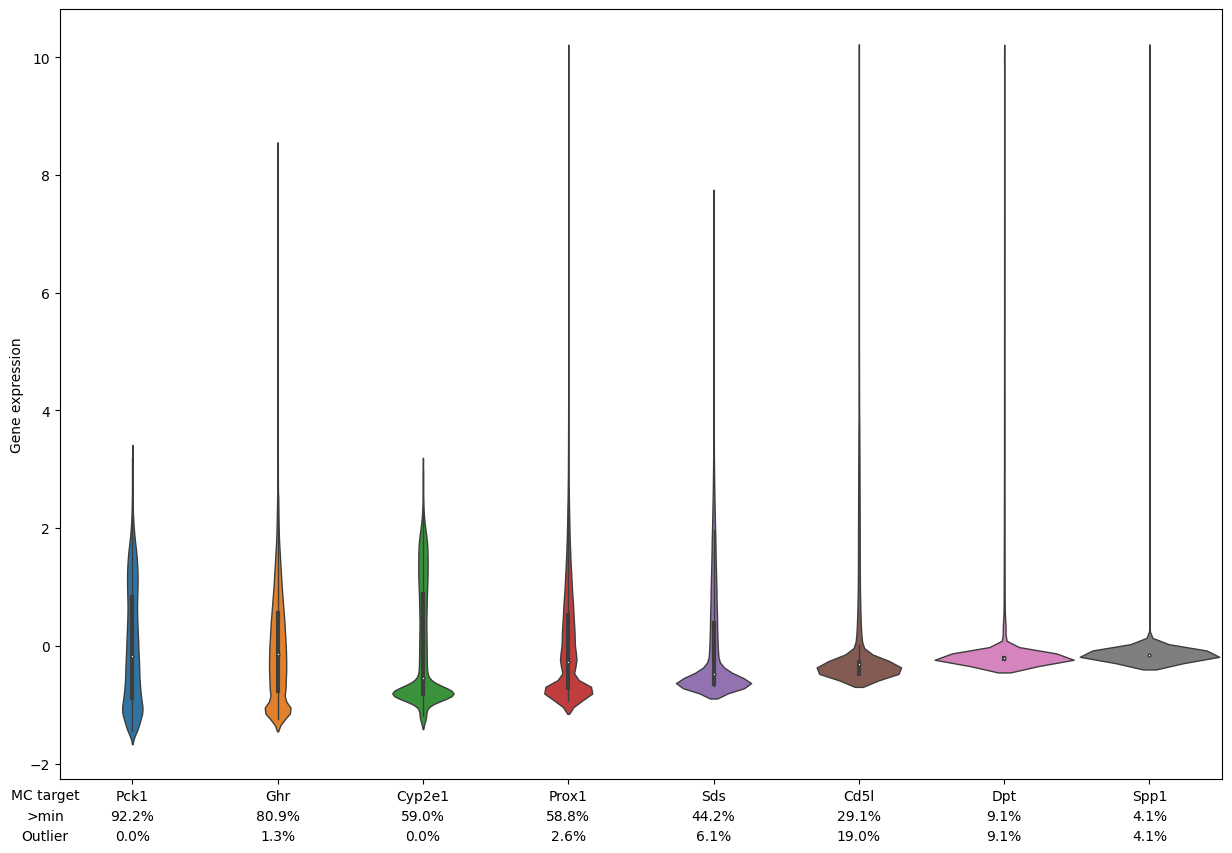

In [56]:
all_genes = dataframe.columns
#random_genes = sample(list(all_genes), 10)
random_genes = ['Pck1','Ghr','Cyp2e1','Prox1','Sds','Cd5l','Dpt','Spp1']
dataframe_kopie = dataframe.copy(deep=True)
dataframe_kopie = dataframe_kopie[random_genes]
plt.figure(figsize=(15,10))
ax = sns.violinplot(data = dataframe_kopie,width=0.96,linewidth=1)
#sns.boxplot(data=dataframe_kopie, saturation=0.5, width=0.4, boxprops={'zorder': 2}, ax=ax)
plt.ylabel('Gene expression')
# add values of the list outliers under the x-axis 
for i in range(len(outliers)):
    plt.text(i,-3.35,str(outliers[i])+'%',ha='center',va='bottom')
plt.text(-0.6,-3.35,'Outlier',ha='center',va='bottom')
plt.text(-0.6,-2.65,'MC target',ha='center',va='bottom')
plt.text(-0.6,-3.01,'>min',ha='center',va='bottom')
for i in range(len(outliers)):
    plt.text(i,-3.01,str(random_genes_perc_count[i])+'%',ha='center',va='bottom')

In [ ]:
annotation = 'annotation_own_score_genes_BasicMartin_12'

In [ ]:
sns.boxplot(y=annotation,x='area',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='eccentricity',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='extent',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='solidity',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='intensity_mean',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='distance_to_edge',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()
sns.boxplot(y=annotation,x='distance_to_vein',data=anndata_samples_together.obs,whis=(5,90),showfliers=False)
plt.show()

In [73]:
def compare_features_of_ct_between_annotations(anndata,annotations,annotations_names,celltype,plot=True,columns=[]):
    if columns == []:
        df = pd.DataFrame(columns=['annotation', 'area', 'eccentricity', 'extent', 'solidity', 'intensity_mean', 'distance_to_edge', 'distance_to_vein'])
    else:
        df = pd.DataFrame(columns=['annotation'] + columns)
    for annotation in annotations:
        df_add = anndata.obs[anndata.obs[annotation] == celltype]
        if columns == []:
            df_add = df_add.drop(columns=[col for col in df_add.columns if col not in ['area', 'eccentricity', 'extent', 'solidity', 'intensity_mean', 'distance_to_edge', 'distance_to_vein']])
        else:
            df_add = df_add.drop(columns=[col for col in df_add.columns if col not in columns])
        df_add['annotation'] = annotations_names[annotations.index(annotation)]
        df = pd.concat([df, df_add])
    df['annotation'] = df['annotation'].astype('category')
    df = df.reset_index(drop=True)
    if plot:
        for column in df.columns:
            if column != 'annotation':
                sns.boxplot(y='annotation',x=column,data=df,whis=(5,90),showfliers=False)
                plt.title(celltype)
                plt.show()
    return df

In [12]:
anndata = anndata_samples_together
annotations_names = ['Score_Genes_Binned [Martin1]','Score_Genes_Binned [Martin2]','Score_Genes_Binned [Atlas(_Score)_12]','Score_Genes_Binned [Atlas(_Score)_7]', 'Tangram [snRNA-seq]','Score_Genes_Iterative [Martin1]','Score_Genes_Iterative [Martin2]','Score_Genes_Iterative [Atlas_12]','Score_Genes_Iterative [Atlas_Score_12]','Score_Genes_Iterative [Atlas_7]','Score_Genes_Iterative [Atlas_Score_7]']
annotations = ['annotation_score_genes_original_BasicMartin_12','annotation_score_genes_original_HLMartin_12','annotation_score_genes_original_Atlas_12','annotation_score_genes_original_Atlas_7','annotation_tangram_11','annotation_own_score_genes_BasicMartin_12','annotation_own_score_genes_HLMartin_12','annotation_own_score_genes_Atlas_12','annotation_own_score_genes_Atlas_Scores_12','annotation_own_score_genes_Atlas_7','annotation_own_score_genes_Atlas_Scores_7']

In [51]:
df_median = pd.DataFrame(columns=['cell type','annotation', 'area', 'eccentricity', 'extent', 'solidity', 'intensity_mean', 'distance_to_edge', 'distance_to_vein'])
celltypes = ['Hepa','Chol','LSEC','Central vein','Portal vein','Kupf','Oth im','B cell','Portal LAM','Meso','Stel','Fibr','Unknown','Strom','Endo']
for celltype in celltypes:
    df = compare_features_of_ct_between_annotations(anndata,annotations,annotations_names,celltype,plot=False)
    df['cell type'] = celltype
    for annotation in annotations_names:
        df_annotation = df[df['annotation'] == annotation]
        # take the median of the features
        df_annotation = df_annotation.median()
        row = [celltype,annotation] + df_annotation.to_list()
        # check if there are NaN values
        if len(row) == len(df_median.columns):
            df_median = df_median.append(pd.Series(row, index=df_median.columns), ignore_index=True)

In [66]:
anndata_samples_together.obs[annotations[0]].value_counts()
# fraction of value counts
anndata_samples_together.obs[annotations[0]].value_counts(normalize=True).to_dict()
for annotation in annotations:
    dict_fractions = anndata_samples_together.obs[annotation].value_counts(normalize=True).to_dict()
    for ct in dict_fractions:
        if dict_fractions[ct] < 0.0005:
            print(annotation)
            print(ct)
            print('')
df_median = df_median.drop(df_median[(df_median['cell type'] == 'Unknown') & (df_median['annotation'] == 'Score_Genes_Binned [Martin1]')].index)

annotation_score_genes_original_BasicMartin_12
Unknown



In [19]:
name_dict = {'Hepa':'Hepatocyte',
 'Endo':'Endothelial cell',
 'Strom':'Stromal cell',
 'B cell':'B cell',
 'Kupf':'Kupffer cell',
 'Chol':'Cholangiocyte',
 'Oth im':'Other immune cells',
 'Portal vein':'PVEC',
 'Central vein':'CVEC',
 'LSEC':'LSEC',
 'Meso':'Mesothelial cell',
 'Fibr':'Fibroblast',
 'Stel':'Stellate cell',
 'Portal LAM':'Portal LAM',
 'Unknown':'Unknown'}

color_dict_RESOLVE={'B cell': '#a4be5c', 
'Cholangiocyte': '#7f007f', 
'Hepatocyte': '#ff8c00', 
'Kupffer cell': '#ff0000', 
'LSEC': '#2a9df4',
'Mesothelial cell': '#7b3f00', 
'CVEC': '#0000cd', 
'PVEC': '#00ffff', 
'Other immune cell': '#2e8b57', 
'Fibroblast': '#ff1493',
'Stellate cell': '#ffea17', 
'Portal LAM': '#00fa9a', 
'Endothelial cell': '#c4d4e0', 
'Stromal cell': '#ffc9ed',
'unknown_celltype': '#696969', #dim gray
'Unknown': '#696969'} #dim gray

In [63]:
df_median['cell type'] = df_median['cell type'].map(name_dict)

In [67]:
feature_name_dict={'area': 'Area', 
'eccentricity': 'Eccentricity', 
'extent': 'Extent', 
'solidity': 'Solidity', 
'intensity_mean': 'Mean intensity',
'distance_to_edge': 'Distance to the nearest edge of the sample', 
'distance_to_vein': 'Distance to the nearest vein',
'distance_to_edge_tissue': 'Distance to the nearest edge of the tissue'}

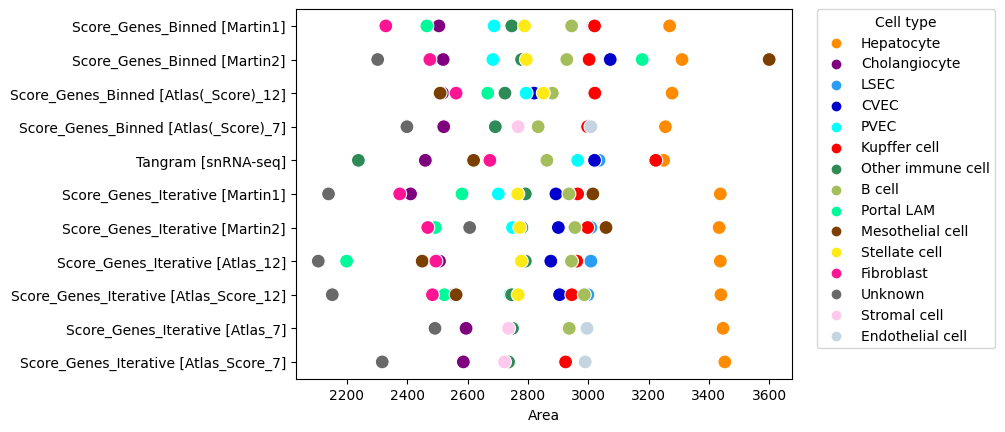

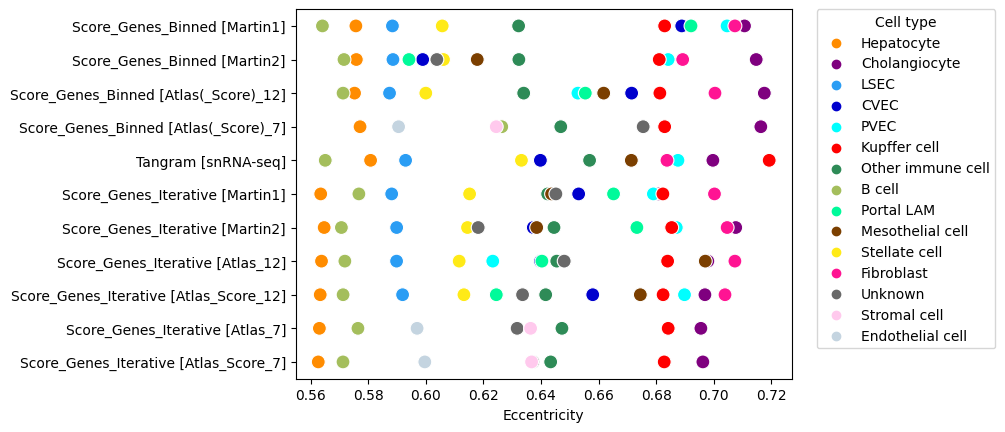

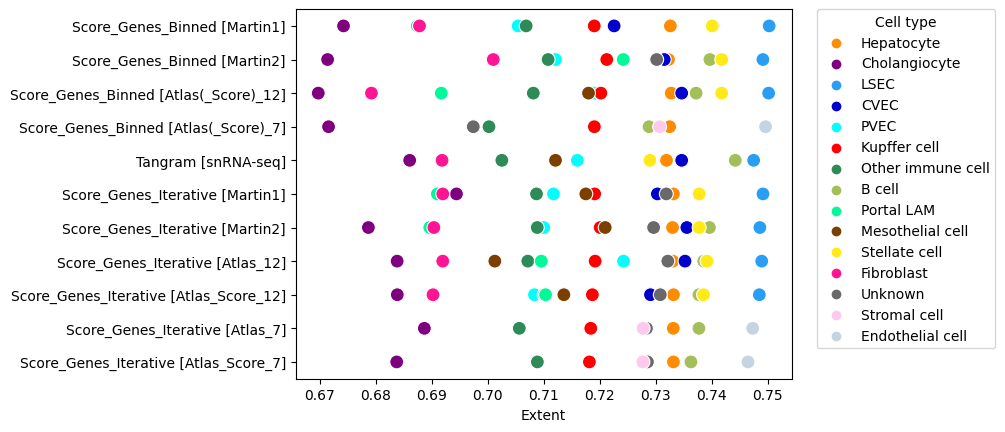

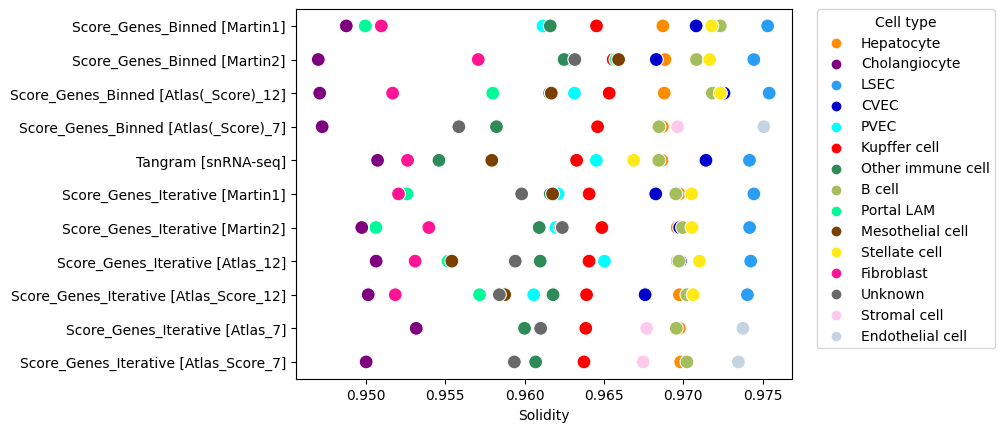

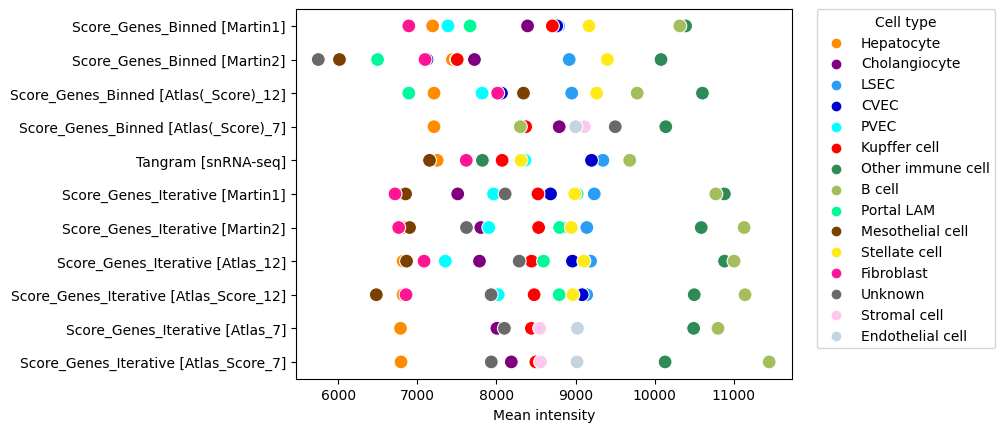

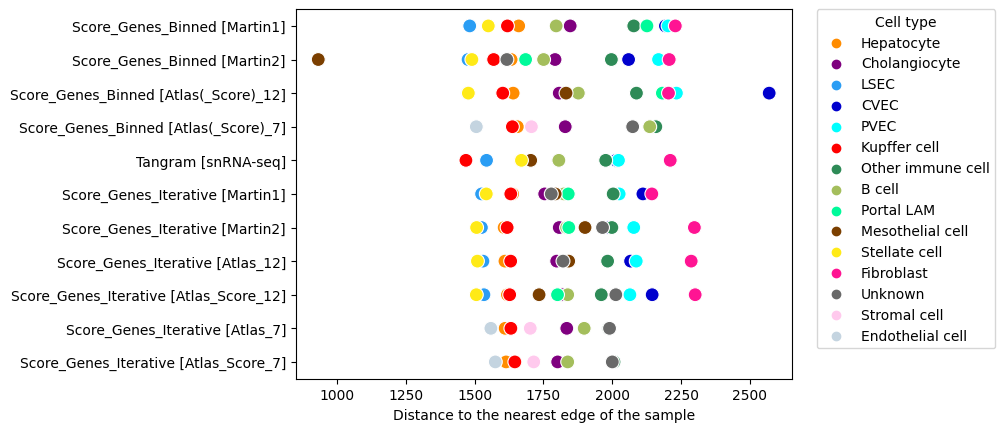

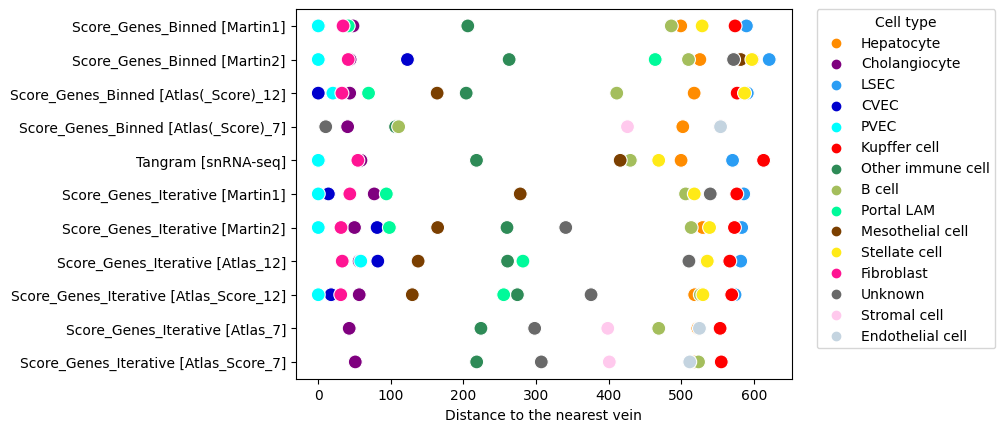

In [65]:
for feature in ['area', 'eccentricity', 'extent', 'solidity', 'intensity_mean', 'distance_to_edge', 'distance_to_vein']:
    sns.scatterplot(x=feature,y='annotation',hue='cell type',palette=color_dict_RESOLVE,data=df_median,s=100,alpha=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Cell type')
    plt.xlabel(feature_name_dict[feature])
    plt.ylabel('')
    plt.show()

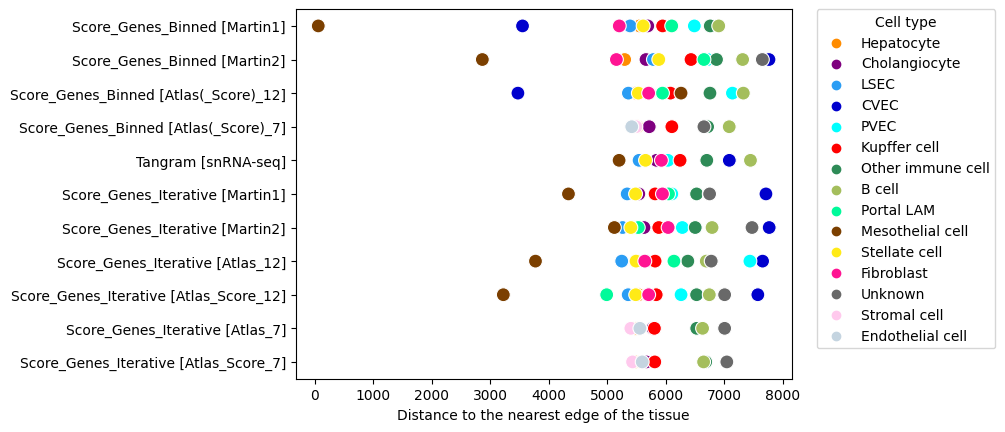

,cell type,annotation,distance_to_edge_tissue
0,Hepatocyte,Score_Genes_Binned [Martin1],5551.698541
1,Hepatocyte,Score_Genes_Binned [Martin2],5296.841967
2,Hepatocyte,Score_Genes_Binned [Atlas(_Score)_12],5480.386382
3,Hepatocyte,Score_Genes_Binned [Atlas(_Score)_7],5512.691623
4,Hepatocyte,Tangram [snRNA-seq],5557.55072
...,...,...,...
119,Stromal cell,Score_Genes_Iterative [Atlas_7],5402.70312
120,Stromal cell,Score_Genes_Iterative [Atlas_Score_7],5431.675918
121,Endothelial cell,Score_Genes_Binned [Atlas(_Score)_7],5417.793093
122,Endothelial cell,Score_Genes_Iterative [Atlas_7],5557.041119


In [74]:
name_anndata = "A1-1"+"/"+"anndataNucA11"
anndata = anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold_distance_edge_tissue')
annotations_names = ['Score_Genes_Binned [Martin1]','Score_Genes_Binned [Martin2]','Score_Genes_Binned [Atlas(_Score)_12]','Score_Genes_Binned [Atlas(_Score)_7]', 'Tangram [snRNA-seq]','Score_Genes_Iterative [Martin1]','Score_Genes_Iterative [Martin2]','Score_Genes_Iterative [Atlas_12]','Score_Genes_Iterative [Atlas_Score_12]','Score_Genes_Iterative [Atlas_7]','Score_Genes_Iterative [Atlas_Score_7]']
annotations = ['annotation_score_genes_original_BasicMartin_12','annotation_score_genes_original_HLMartin_12','annotation_score_genes_original_Atlas_12','annotation_score_genes_original_Atlas_7','annotation_tangram_11','annotation_own_score_genes_BasicMartin_12','annotation_own_score_genes_HLMartin_12','annotation_own_score_genes_Atlas_12','annotation_own_score_genes_Atlas_Scores_12','annotation_own_score_genes_Atlas_7','annotation_own_score_genes_Atlas_Scores_7']
df_median = pd.DataFrame(columns=['cell type','annotation', 'distance_to_edge_tissue'])
celltypes = ['Hepa','Chol','LSEC','Central vein','Portal vein','Kupf','Oth im','B cell','Portal LAM','Meso','Stel','Fibr','Unknown','Strom','Endo']
for celltype in celltypes:
    df = compare_features_of_ct_between_annotations(anndata,annotations,annotations_names,celltype,plot=False,columns=['distance_to_edge_tissue'])
    df['cell type'] = celltype
    for annotation in annotations_names:
        df_annotation = df[df['annotation'] == annotation]
        # take the median of the features
        df_annotation = df_annotation.median()
        row = [celltype,annotation] + df_annotation.to_list()
        # check if there are NaN values
        if len(row) == len(df_median.columns):
            df_median = df_median.append(pd.Series(row, index=df_median.columns), ignore_index=True)
df_median = df_median.drop(df_median[(df_median['cell type'] == 'Unknown') & (df_median['annotation'] == 'Score_Genes_Binned [Martin1]')].index)
df_median['cell type'] = df_median['cell type'].map(name_dict)
feature = 'distance_to_edge_tissue'
sns.scatterplot(x=feature,y='annotation',hue='cell type',palette=color_dict_RESOLVE,data=df_median,s=100,alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Cell type')
plt.xlabel(feature_name_dict[feature])
plt.ylabel('')
plt.show()
df_median

In [ ]:
score_name = 'own_score_genes_Atlas_Scores_12'
score_matrices = []
for i in range(len(anndata_objects)):
    score_matrices.append(anndata_objects[i].uns[score_name])
score_matrix_together = pd.concat(score_matrices)
# set smaller than 0 to NaN
score_matrix_together[score_matrix_together < 0] = np.nan


In [ ]:
score_matrix_together

In [ ]:
score_matrix_together_max = score_matrix_together.copy()
for i in range(score_matrix_together_max.shape[0]):
    max_value = score_matrix_together_max.iloc[i,:].max()
    score_matrix_together_max.iloc[i,score_matrix_together_max.iloc[i,:] < max_value] = np.nan

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=score_matrix_together_max,ax=ax)
plt.xticks(rotation=90)
plt.title('Boxplot of winning scores per cell type')
plt.ylabel('score')
# add to each x label the percentage that is not NaN
for i in range(len(ax.get_xticklabels())):
    ax.text(i,-2,str(round(100*sum(score_matrix_together_max.iloc[:,i]>0)/len(score_matrix_together_max.iloc[:,i]),2))+'%',ha='center', fontsize=12)
plt.show()

In [ ]:
annotation = 'annotation_score_genes_original_Atlas_Scores_12'
cell_types = anndata_samples_together.obs[annotation].unique().tolist()  
# move 'Unknown' to last place
cell_types.remove('Unknown')
cell_types.append('Unknown')
# remove 'Hepa' from cell_types
cell_types_no_hepa = [x for x in cell_types if x != 'Hepa']
leiden_clusters_per_ct = clusteringVSleiden(anndata_samples_together,annotation,"leiden",cell_types=cell_types,print_results=True,cell_types_in_homog_plot=cell_types_no_hepa,homog_plot_only_hepa=True)

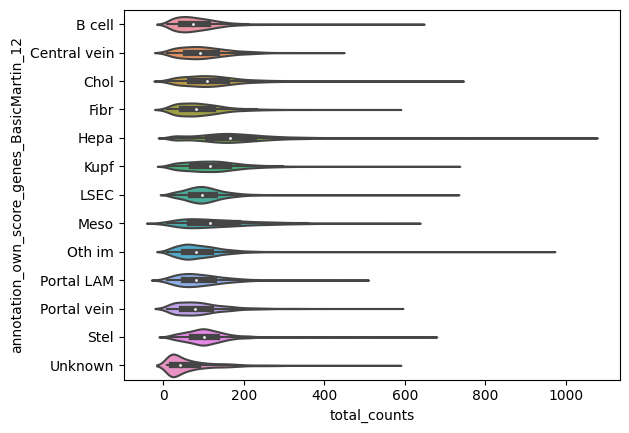

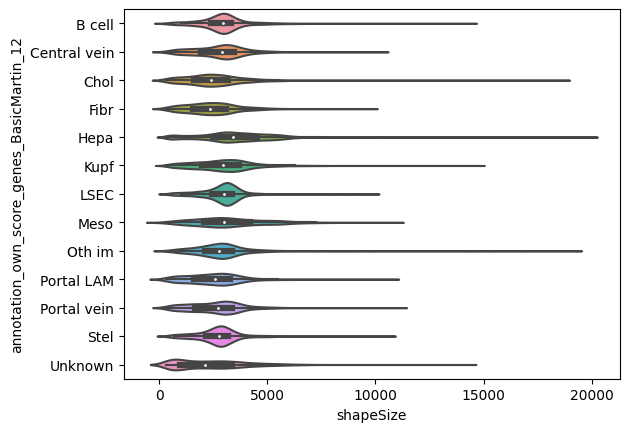

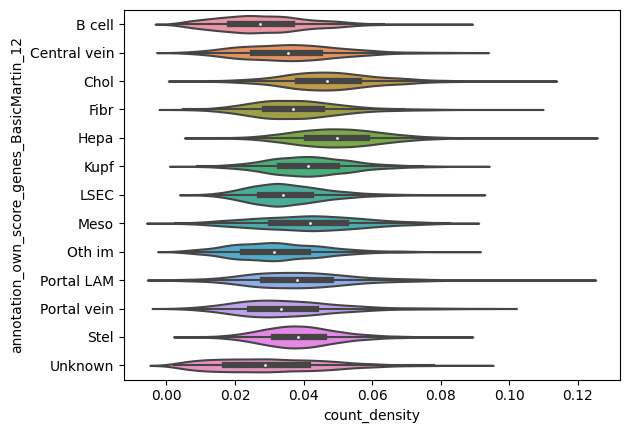

In [8]:
anndata = anndata_samples_together
annotation = 'annotation_own_score_genes_BasicMartin_12'
sns.violinplot(data=anndata.obs,x="total_counts",y=annotation)
plt.show()
sns.violinplot(data=anndata.obs,x="shapeSize",y=annotation)
plt.show()
anndata.obs['count_density'] = anndata.obs['total_counts'] / anndata.obs['shapeSize']
sns.violinplot(data=anndata.obs,x="count_density",y=annotation)
plt.show()

In [34]:
anndata = anndata_objects[0]
anndata.obs['total_counts_ln'] = np.log(anndata.obs['total_counts']) #ln
anndata.obs['log(transcript count)'] = np.log10(anndata.obs['total_counts']) #log

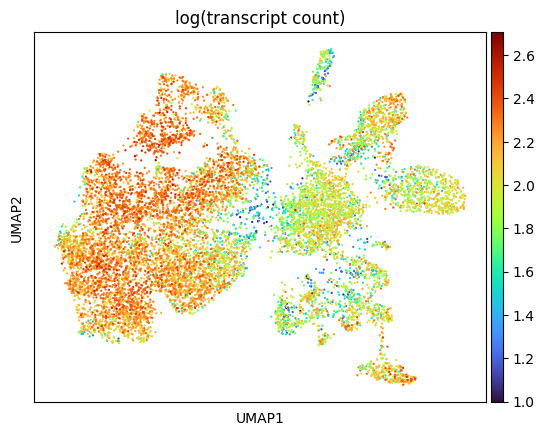

In [35]:
sc.pl.umap(anndata,color='log(transcript count)',color_map='turbo')

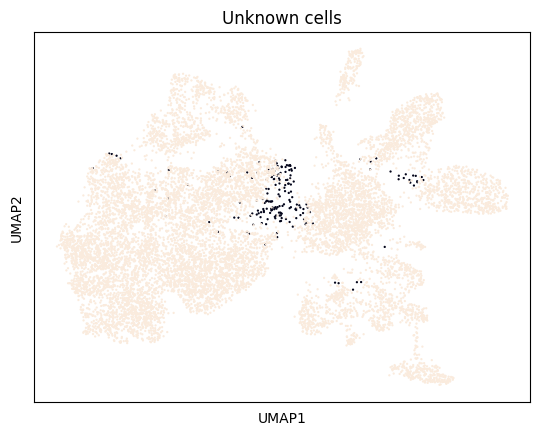

dict_keys(['annotation_colors', 'annotation_own_score_genes_Atlas_12_colors', 'annotation_own_score_genes_Atlas_7_colors', 'annotation_own_score_genes_Atlas_Scores_12_colors', 'annotation_own_score_genes_Atlas_Scores_7_colors', 'annotation_own_score_genes_BasicMartin_12_colors', 'annotation_own_score_genes_BasicMartin_7_colors', 'annotation_own_score_genes_HLMartin_12_colors', 'annotation_own_score_genes_HLMartin_7_colors', 'annotation_own_score_genes_start_iterative_Atlas_12_colors', 'annotation_own_score_genes_start_iterative_Atlas_7_colors', 'annotation_own_score_genes_start_iterative_Atlas_Scores_12_colors', 'annotation_own_score_genes_start_iterative_Atlas_Scores_7_colors', 'annotation_own_score_genes_start_iterative_BasicMartin_12_colors', 'annotation_own_score_genes_start_iterative_BasicMartin_7_colors', 'annotation_own_score_genes_start_iterative_HLMartin_12_colors', 'annotation_own_score_genes_start_iterative_HLMartin_7_colors', 'annotation_score_genes_original_Atlas_12_colors

In [64]:
anndata.obs['Unknown_annotation_own_score_genes_BasicMartin_12'] = anndata.obs['annotation_own_score_genes_BasicMartin_12'] 
anndata.obs['Unknown cells'] = np.where(anndata.obs['Unknown_annotation_own_score_genes_BasicMartin_12'] == 'Unknown', 0, 1)
# plot UMAP with Unknown and non-Unknown cells
sc.pl.umap(anndata,color='Unknown cells',color_map='rocket',colorbar_loc=None)
anndata.uns.keys()

In [ ]:
annotation = 'annotation_score_genes_original_Atlas_Scores_12'
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/AtlasSecondLevelScores.csv"
name = 'Atlas Scores'
# drop first 11 characters
annotation_scores = annotation[11:]

Index(['LSEC', 'Portal LAM', 'Central vein', 'Portal vein', 'Hepa', 'Chol',
       'B cell', 'Kupf', 'Meso', 'Stel', 'Fibr', 'Oth im'],
      dtype='object')
Index(['LSEC', 'Portal LAM', 'Central vein', 'Portal vein', 'Hepa', 'Chol',
       'B cell', 'Kupf', 'Meso', 'Stel', 'Fibr', 'Oth im'],
      dtype='object')
Index(['LSEC', 'Portal LAM', 'Central vein', 'Portal vein', 'Hepa', 'Chol',
       'B cell', 'Kupf', 'Meso', 'Stel', 'Fibr', 'Oth im'],
      dtype='object')
Index(['LSEC', 'Portal LAM', 'Central vein', 'Portal vein', 'Hepa', 'Chol',
       'B cell', 'Kupf', 'Meso', 'Stel', 'Fibr', 'Oth im'],
      dtype='object')
score_genes_original_Atlas_12


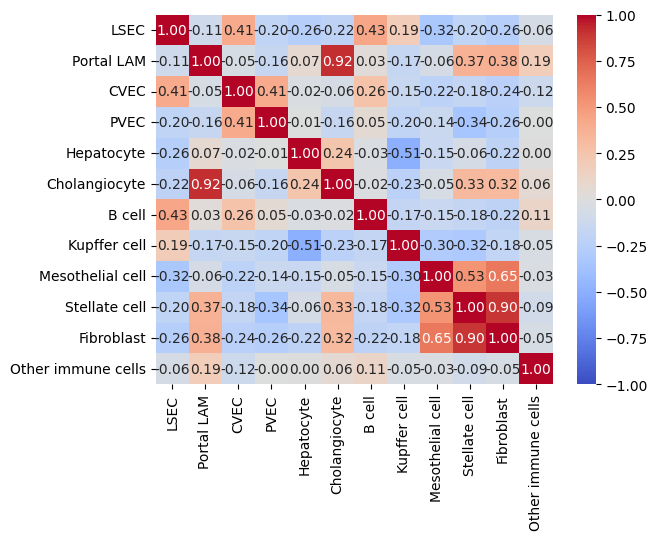

In [72]:
annotations = ['annotation_score_genes_original_BasicMartin_12','annotation_score_genes_original_HLMartin_12','annotation_score_genes_original_Atlas_12','annotation_score_genes_original_Atlas_7','annotation_tangram_11','annotation_own_score_genes_BasicMartin_12','annotation_own_score_genes_HLMartin_12','annotation_own_score_genes_Atlas_12','annotation_own_score_genes_Atlas_Scores_12','annotation_own_score_genes_Atlas_7','annotation_own_score_genes_Atlas_Scores_7']
annotation = annotations[2]
annotation_scores = annotation[11:]
corr_matrices = []
for anndata in anndata_objects:
    scores = anndata.uns[annotation_scores]
    #scores = anndata.uns['tangram']
    corr_matrix = scores.corr(method='pearson')
    corr_matrices.append(corr_matrix)   
# average df in corr_matrices
average_corr_matrix = sum(corr_matrices)/len(corr_matrices)
average_corr_matrix
# make heatmap
fig, ax = plt.subplots(1,1)
sns.heatmap(average_corr_matrix, ax=ax, annot=True,fmt='.2f',vmin=-1, vmax=1, cmap='coolwarm')
old_labels = anndata.uns[annotation_scores].columns.to_list()
new_labels = []
for label in old_labels:
    new_labels.append(name_dict[label])
ax.set_xticklabels(new_labels,rotation=90)
ax.set_yticklabels(new_labels,rotation=0)
print(annotation_scores)
# add title
# plt.title('Score correlation matrix '+name)

In [30]:
anndata_objects[0].uns['tangram']

,Stel,Meso,LSEC,Portal vein,Hepa,Chol,Fibr,Central vein,Oth im,B cell,Kupf
cells,,,,,,,,,,,
65,0.256320,2.398002,0.001510,0.000216,0.007905,0.001412,0.054258,0.000252,0.000348,0.000252,0.000456
66,0.099836,0.107797,0.136875,0.000680,0.737168,0.006554,0.112484,0.001103,0.001312,0.000926,0.410406
67,0.006982,1.504063,0.001371,0.000328,0.022586,0.000988,0.468502,0.000396,0.002208,0.000362,0.001848
129,0.102877,1.248521,0.009553,0.000501,0.019981,0.038718,0.249460,0.000635,0.000971,0.000581,0.000949
130,0.053507,0.016417,0.001482,0.000323,0.059873,0.001194,1.774873,0.000453,0.003539,0.000372,0.010608
...,...,...,...,...,...,...,...,...,...,...,...
32713,0.435256,0.007303,0.004222,0.000524,0.717283,0.002399,0.009896,0.000679,0.001304,0.000671,0.489971
32777,0.061996,0.043053,0.004029,0.000804,1.440941,0.013852,0.008086,0.001035,0.004174,0.001037,0.001977
32841,0.366320,0.021685,0.006118,0.019996,0.143102,0.014492,0.016830,0.007099,0.000939,0.000828,1.017046


In [ ]:
Jacc_m = Jaccard_similarity_matrix(path_mg,name)

In [ ]:
# subtract matrices
diff_matrix = average_corr_matrix - Jacc_m
sns.heatmap(diff_matrix, annot=True,fmt='.2f',vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Score correlation - Jaccard matrix '+name)

own_score_genes_Atlas_Scores_7


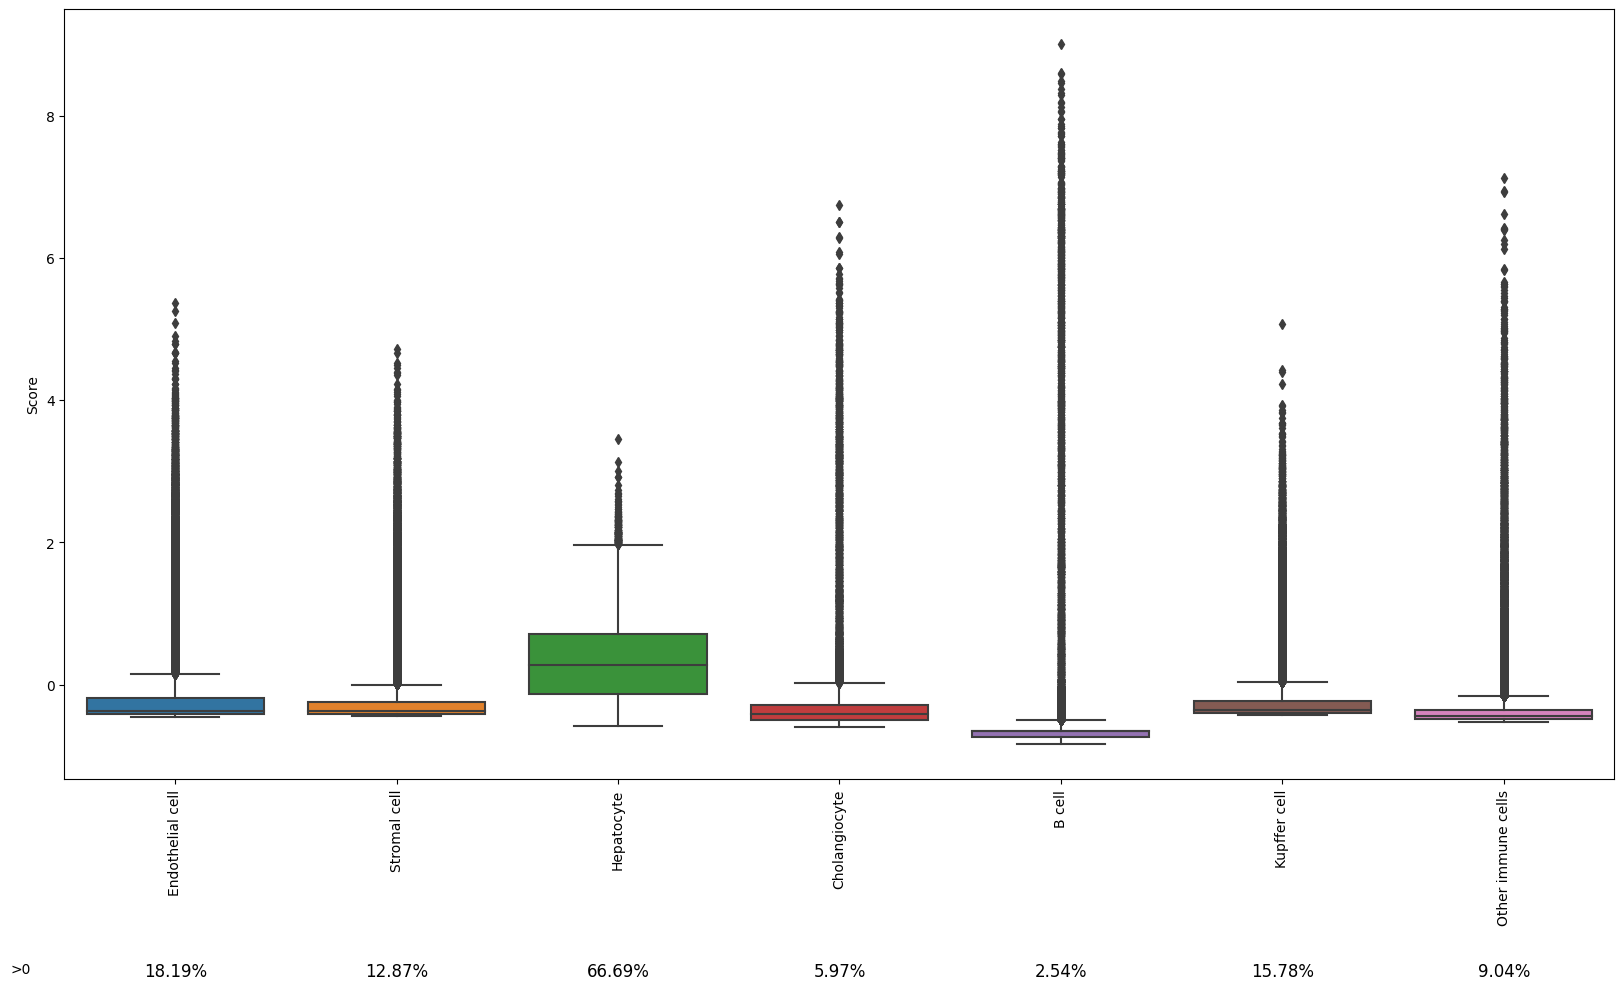

In [119]:
annotations = ['annotation_score_genes_original_BasicMartin_12','annotation_score_genes_original_HLMartin_12','annotation_score_genes_original_Atlas_12','annotation_score_genes_original_Atlas_7','annotation_tangram_11','annotation_own_score_genes_BasicMartin_12','annotation_own_score_genes_HLMartin_12','annotation_own_score_genes_Atlas_12','annotation_own_score_genes_Atlas_Scores_12','annotation_own_score_genes_Atlas_7','annotation_own_score_genes_Atlas_Scores_7']
annotation = annotations[10]
annotation_scores = annotation[11:]
#annotation_scores = 'tangram'
print(annotation_scores)

dataframes_scores = []
for anndata in anndata_objects:
    scores_df = anndata.uns[annotation_scores]
    dataframes_scores.append(scores_df)
scores = pd.concat(dataframes_scores)

fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=scores,ax=ax)
plt.xticks(rotation=90)
plt.ylabel('Score')
depth = -4.1
for i in range(len(ax.get_xticklabels())):
    ax.text(i,depth,str(round(100*sum(scores.iloc[:,i]>0)/len(scores.iloc[:,i]),2))+'%',ha='center', fontsize=12)
old_labels = anndata.uns[annotation_scores].columns.to_list()
new_labels = []
for label in old_labels:
    new_labels.append(name_dict[label])
ax.set_xticklabels(new_labels,rotation=90)
plt.text(-0.7,depth,'>0',ha='center',va='bottom')
plt.show()

own_score_genes_Atlas_Scores_7


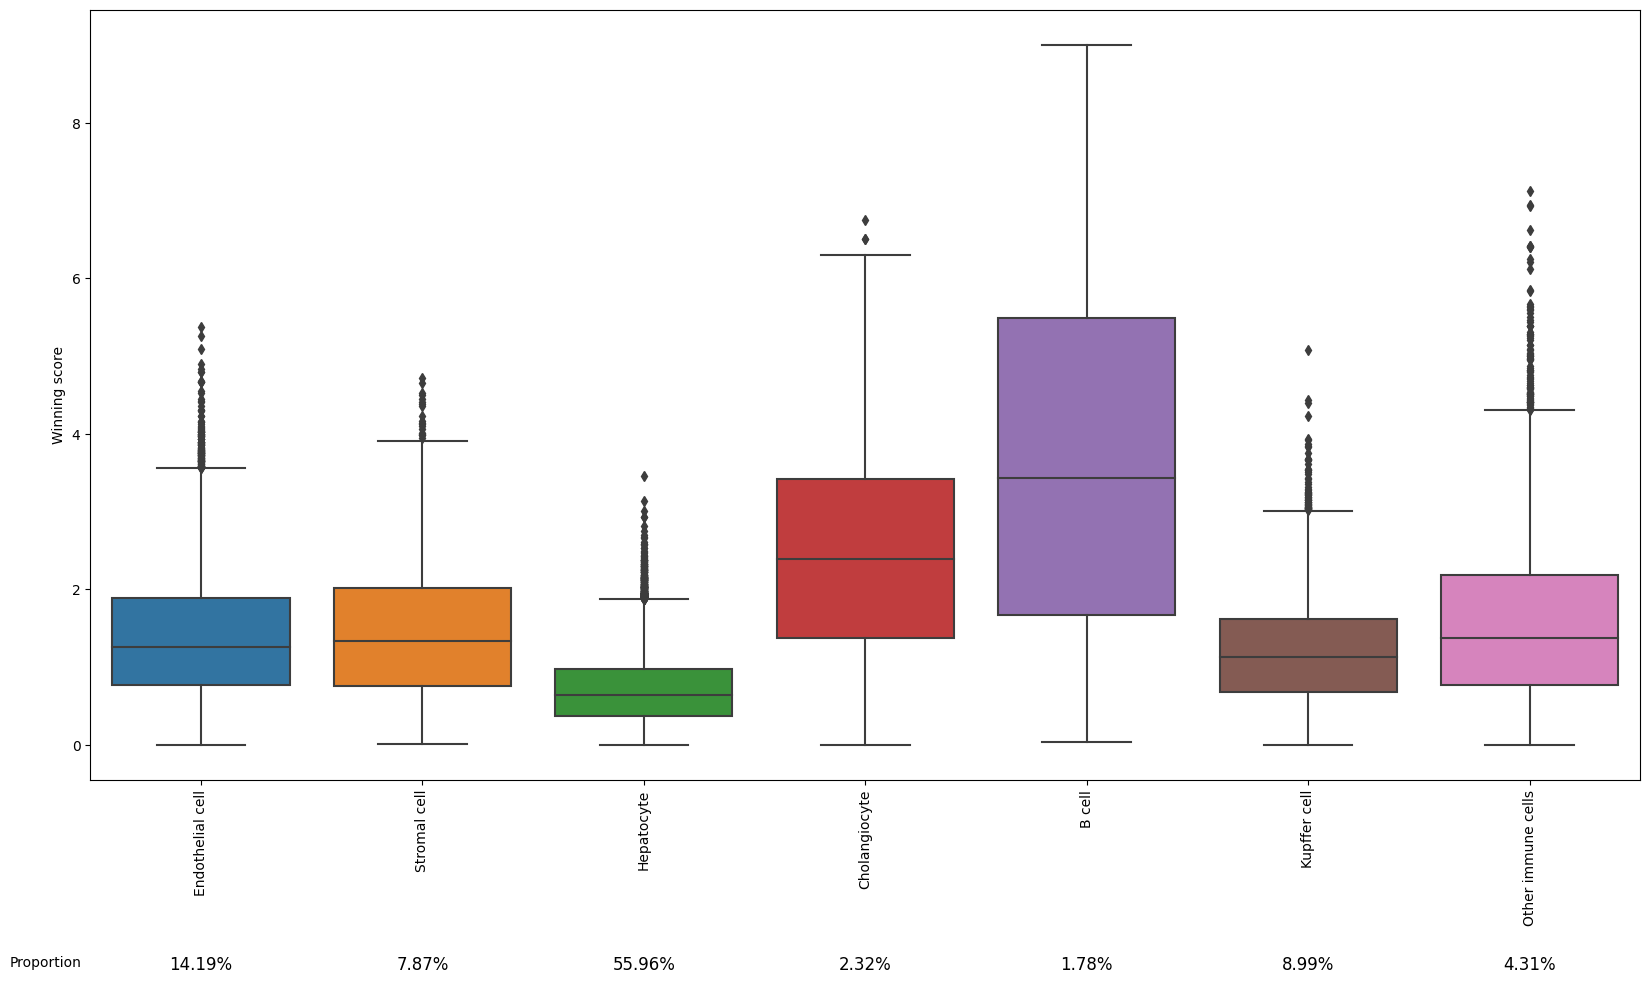

In [176]:
annotations = ['annotation_score_genes_original_BasicMartin_12','annotation_score_genes_original_HLMartin_12','annotation_score_genes_original_Atlas_12','annotation_score_genes_original_Atlas_7','annotation_tangram_11','annotation_own_score_genes_BasicMartin_12','annotation_own_score_genes_HLMartin_12','annotation_own_score_genes_Atlas_12','annotation_own_score_genes_Atlas_Scores_12','annotation_own_score_genes_Atlas_7','annotation_own_score_genes_Atlas_Scores_7']
annotation = annotations[10]
annotation_scores = annotation[11:]
#annotation_scores = 'tangram'
print(annotation_scores)

dataframes_scores = []
dataframe_proportions = []
for anndata in anndata_objects:
    scores = anndata.uns[annotation_scores]
    for i in range(scores.shape[0]):
        max_value = scores.iloc[i,:].max()
        if max_value > 0:
            scores.iloc[i,scores.iloc[i,:] < max_value] = np.nan
        else:
            scores.iloc[i,:] = np.nan
    dataframes_scores.append(scores)
    proportions = []
    for j in range(scores.shape[1]):
        proportions.append(round(100*sum(scores.iloc[:,j]>0)/len(scores.iloc[:,]),2))
    dataframe_proportions.append(proportions)
scores = pd.concat(dataframes_scores)
proportions_mean = np.round(np.mean(dataframe_proportions,axis=0),2).tolist()

fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=scores,ax=ax)
plt.xticks(rotation=90)
plt.ylabel('Winning score')
depth = -2.9
for i in range(len(ax.get_xticklabels())):
    ax.text(i,depth,str(proportions_mean[i])+'%',ha='center', fontsize=12)
old_labels = anndata.uns[annotation_scores].columns.to_list()
new_labels = []
for label in old_labels:
    new_labels.append(name_dict[label])
ax.set_xticklabels(new_labels,rotation=90)
plt.text(-0.7,depth,'Proportion',ha='center',va='bottom')
plt.show()
